<a href="https://colab.research.google.com/github/AmanPant9026/AmanPant9026/blob/main/Hotel_Reviews_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install autocorrect
!pip install corextopic


In [5]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import spacy
import csv
import nltk
import matplotlib.pyplot as plt
import warnings
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, SpectralClustering, MeanShift
from sklearn.decomposition import PCA,TruncatedSVD,NMF
from sklearn import svm
from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve,confusion_matrix, f1_score
from nltk.corpus import stopwords
from autocorrect import Speller
from matplotlib import pyplot as plt
from corextopic import corextopic as ct
from corextopic import vis_topic as vt
from collections import Counter,Counter,defaultdict
from scipy.linalg import svd
from sklearn.tree import DecisionTreeClassifier
spell = Speller(lang='en')
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")


# Importing data and EDA:

In [12]:
!pwd  # Displays the current working directory
!ls   # Lists all files in the working directory


/content
Hotel_Reviews.csv  sample_data


In [13]:
import pandas as pd

file_path = '/content/Hotel_Reviews.csv'  # Path to the file in Colab
df_original_data = pd.read_csv(file_path, on_bad_lines='skip')  # Skip problematic rows
df_all_data = df_original_data.copy()

# Display the first few rows to confirm successful loading
print(df_original_data.head())



                                       Hotel_Address  \
0   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
1   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
2   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
3   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
4   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   

  Additional_Number_of_Scoring Review_Date  Average_Score   Hotel_Name  \
0                          194    8/3/2017            7.7  Hotel Arena   
1                          194    8/3/2017            7.7  Hotel Arena   
2                          194   7/31/2017            7.7  Hotel Arena   
3                          194   7/31/2017            7.7  Hotel Arena   
4                          194   7/24/2017            7.7  Hotel Arena   

  Reviewer_Nationality                                    Negative_Review  \
0              Russia    I am so angry that i made this post available...   
1             Ireland                                         No

feature engineering: getting Countries Column  from hotel address columns:

In [14]:
def get_contries():
    df_all_data['Country'] = df_all_data.Hotel_Address.apply(lambda x: str(x).split(" ")[-1])
    df_all_data['Country'] = df_all_data['Country'].str.replace('Kingdom','United Kingdom')
get_contries()

In [15]:
df_all_data

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng,Country
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11.0,7.0,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968,Netherlands
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105.0,7.0,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968,Netherlands
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21.0,9.0,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968,Netherlands
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26.0,1.0,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968,Netherlands
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8.0,3.0,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968,Netherlands
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533929,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,8/30/2015,8.1,Atlantis Hotel Vienna,Kuwait,no trolly or staff to help you take the lugga...,14,2823,location,2,8.0,7.0,"[' Leisure trip ', ' Family with older childre...",704 day,48.203745,16.335677,Austria
533930,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,8/22/2015,8.1,Atlantis Hotel Vienna,Estonia,The hotel looks like 3 but surely not 4,11,2823,Breakfast was ok and we got earlier check in,11,12.0,5.8,"[' Leisure trip ', ' Family with young childre...",712 day,48.203745,16.335677,Austria
533931,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,8/19/2015,8.1,Atlantis Hotel Vienna,Egypt,The ac was useless It was a hot week in vienn...,19,2823,No Positive,0,3.0,2.5,"[' Leisure trip ', ' Family with older childre...",715 day,48.203745,16.335677,Austria
533932,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,8/17/2015,8.1,Atlantis Hotel Vienna,Mexico,No Negative,0,2823,The rooms are enormous and really comfortable...,25,3.0,8.8,"[' Leisure trip ', ' Group ', ' Standard Tripl...",717 day,48.203745,16.335677,Austria


In [16]:
df_all_data['Country'].unique()

array(['Netherlands', 'United Kingdom', 'France', '', 'Mirabeau', 'Spain',
       'Italy', 'Austria'], dtype=object)

In [17]:
df_all_data['Country'].value_counts()

,count
Country,
United Kingdom,275322
France,65100
Spain,60149
Netherlands,57214
Austria,38939
Italy,37207
,2
Mirabeau,1


Dividing Data into two parts, positive reviews and negative reviews:

In [18]:
df_pos = df_all_data[['Positive_Review','Hotel_Name','Country','Reviewer_Score','Reviewer_Nationality']]
df_neg = df_all_data[['Negative_Review','Hotel_Name','Country','Reviewer_Score','Reviewer_Nationality']]
df_recom = df_all_data[['Reviewer_Nationality','Hotel_Name','Reviewer_Score']]

Renaming columns from ('Positive_Review''Negative_Review') to Review

In [19]:
df_pos.rename(columns = {'Positive_Review':'Review'},inplace= True)
df_neg.rename(columns = {'Negative_Review':'Review'},inplace= True)

Making new Column named Sentiment and assigning 1 to positive review and 0 to negative review

In [20]:
df_pos['Sentiment'] = 1
df_neg['Sentiment'] = 0
df_all = pd.concat([df_pos,df_neg],ignore_index=True)
df_drop = df_all.drop_duplicates()

data contain non english letters. code below removes all non english reviews

In [22]:
# Drop rows where 'Review' is NaN
df_drop = df_drop.dropna(subset=['Review'])

# Filter rows where 'Review' contains only ASCII characters
df_drop = df_drop[df_drop['Review'].map(lambda x: str(x).isascii())]


Extra Data cleaning such as removing punctuation, repeated_chars etc...

In [23]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
repeated_chars = lambda x: re.sub('(.)\\1{2,}', '\\1', x)
df_drop['Review'] = df_drop.Review.map(alphanumeric).map(punc_lower).map(repeated_chars)
df_drop

,Review,Hotel_Name,Country,Reviewer_Score,Reviewer_Nationality,Sentiment
0,only the park outside of the hotel was beauti...,Hotel Arena,Netherlands,2.9,Russia,1
1,no real complaints the hotel was great great ...,Hotel Arena,Netherlands,7.5,Ireland,1
2,location was good and staff were ok it is cut...,Hotel Arena,Netherlands,7.1,Australia,1
3,great location in nice surroundings the bar a...,Hotel Arena,Netherlands,3.8,United Kingdom,1
4,amazing location and building romantic setting,Hotel Arena,Netherlands,6.7,New Zealand,1
...,...,...,...,...,...,...
1067863,no trolly or staff to help you take the lugga...,Atlantis Hotel Vienna,Austria,7.0,Kuwait,0
1067864,the hotel looks like but surely not,Atlantis Hotel Vienna,Austria,5.8,Estonia,0
1067865,the ac was useless it was a hot week in vienn...,Atlantis Hotel Vienna,Austria,2.5,Egypt,0
1067866,no negative,Atlantis Hotel Vienna,Austria,8.8,Mexico,0


Data contain over 700,000. taking data sample is necessary. We started from 5000 sample till 100,000. After 100,000  we  noticed that the model is not improving nor changing. So, 100,000 is enough to work on

In [24]:
data_sample = df_drop.sample(100000,random_state=2021)

In [25]:
data_sample['Review'] = data_sample['Review'].map(lambda x: spell(x))

In [27]:
!ls /content


Hotel_Reviews.csv  sample_data


In [29]:
df_drop

,Review,Hotel_Name,Country,Reviewer_Score,Reviewer_Nationality,Sentiment
0,only the park outside of the hotel was beauti...,Hotel Arena,Netherlands,2.9,Russia,1
1,no real complaints the hotel was great great ...,Hotel Arena,Netherlands,7.5,Ireland,1
2,location was good and staff were ok it is cut...,Hotel Arena,Netherlands,7.1,Australia,1
3,great location in nice surroundings the bar a...,Hotel Arena,Netherlands,3.8,United Kingdom,1
4,amazing location and building romantic setting,Hotel Arena,Netherlands,6.7,New Zealand,1
...,...,...,...,...,...,...
1067863,no trolly or staff to help you take the lugga...,Atlantis Hotel Vienna,Austria,7.0,Kuwait,0
1067864,the hotel looks like but surely not,Atlantis Hotel Vienna,Austria,5.8,Estonia,0
1067865,the ac was useless it was a hot week in vienn...,Atlantis Hotel Vienna,Austria,2.5,Egypt,0
1067866,no negative,Atlantis Hotel Vienna,Austria,8.8,Mexico,0


In [30]:
data_sample

,Review,Hotel_Name,Country,Reviewer_Score,Reviewer_Nationality,Sentiment
666430,very small room for three people,Hilton London Metropole,United Kingdom,5.4,Czech Republic,0
717784,they were having some issues with the lifts w...,Strand Palace Hotel,United Kingdom,8.8,Australia,0
1012848,footy woman at floor bar restraint,Ramada Apollo Amsterdam Centre,Netherlands,7.1,United Kingdom,0
782972,the cooked breakfast was luke warm even a fre...,Radisson Blu Edwardian Vanderbilt,United Kingdom,10.0,United Kingdom,0
235577,location was good staff were friendly,New Linden Hotel,United Kingdom,5.0,United Kingdom,1
...,...,...,...,...,...,...
27655,location,Novotel London West,United Kingdom,5.4,United Kingdom,1
244060,excellent location for visiting west london b...,Clayton Hotel Chiswick,United Kingdom,8.8,United Kingdom,1
448739,the room is amazing especially the shower stu...,Le Meridien Vienna,Austria,8.8,Hungary,1
631828,the shower was not very good we could not get...,Courthouse Hotel London,United Kingdom,9.2,United Kingdom,0


Tokenizing and lemmatizing reviews

In [32]:
import nltk

# Download the 'wordnet' resource
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [33]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

data_sample['text_lemmatized'] = data_sample.Review.apply(lemmatize_text)

In [34]:
data_sample['Joined_text_lemmatize'] =  data_sample['text_lemmatized'].apply(lambda x: ' '.join(x))

In [35]:
nlp = spacy.load('en_core_web_sm')
data_sample['spacy_doc'] = list(nlp.pipe(data_sample.Joined_text_lemmatize))
data_sample

,Review,Hotel_Name,Country,Reviewer_Score,Reviewer_Nationality,Sentiment,text_lemmatized,Joined_text_lemmatize,spacy_doc
666430,very small room for three people,Hilton London Metropole,United Kingdom,5.4,Czech Republic,0,"[very, small, room, for, three, people]",very small room for three people,"(very, small, room, for, three, people)"
717784,they were having some issues with the lifts w...,Strand Palace Hotel,United Kingdom,8.8,Australia,0,"[they, were, having, some, issue, with, the, l...",they were having some issue with the lift whic...,"(they, were, having, some, issue, with, the, l..."
1012848,footy woman at floor bar restraint,Ramada Apollo Amsterdam Centre,Netherlands,7.1,United Kingdom,0,"[footy, woman, at, floor, bar, restraint]",footy woman at floor bar restraint,"(footy, woman, at, floor, bar, restraint)"
782972,the cooked breakfast was luke warm even a fre...,Radisson Blu Edwardian Vanderbilt,United Kingdom,10.0,United Kingdom,0,"[the, cooked, breakfast, wa, luke, warm, even,...",the cooked breakfast wa luke warm even a fresh...,"(the, cooked, breakfast, wa, luke, warm, even,..."
235577,location was good staff were friendly,New Linden Hotel,United Kingdom,5.0,United Kingdom,1,"[location, wa, good, staff, were, friendly]",location wa good staff were friendly,"(location, wa, good, staff, were, friendly)"
...,...,...,...,...,...,...,...,...,...
27655,location,Novotel London West,United Kingdom,5.4,United Kingdom,1,[location],location,(location)
244060,excellent location for visiting west london b...,Clayton Hotel Chiswick,United Kingdom,8.8,United Kingdom,1,"[excellent, location, for, visiting, west, lon...",excellent location for visiting west london be...,"(excellent, location, for, visiting, west, lon..."
448739,the room is amazing especially the shower stu...,Le Meridien Vienna,Austria,8.8,Hungary,1,"[the, room, is, amazing, especially, the, show...",the room is amazing especially the shower stuf...,"(the, room, is, amazing, especially, the, show..."
631828,the shower was not very good we could not get...,Courthouse Hotel London,United Kingdom,9.2,United Kingdom,0,"[the, shower, wa, not, very, good, we, could, ...",the shower wa not very good we could not get t...,"(the, shower, wa, not, very, good, we, could, ..."


# Topicing

In [38]:
!pip install openpyxl


In [39]:
import pandas as pd

# Load the Excel file
file_path = '/content/Positive and Negative Word List.xlsx'
word_list = pd.read_excel(file_path)

# Display the first few rows
print(word_list.head())


   Unnamed: 0 Negative Sense Word List Positive Sense Word List
0           0                      NaN                      NaN
1           1                 abnormal                     able
2           2                  abolish                abundance
3           3               abominable               accelerate
4           4               abominably                   accept


In [40]:
positive_reviews = data_sample[data_sample.Sentiment==1]
negative_reviews = data_sample[data_sample.Sentiment==0]

In [41]:
sam_pos_df = positive_reviews.copy()
sam_neg_df = negative_reviews.copy()

In [42]:
sam_pos_df['Review'] = sam_pos_df['Review'].str.replace("hotel" , "")
sam_neg_df['Review'] = sam_neg_df['Review'].str.replace("hotel" , "")

## WordCloud for Positive Reviews:

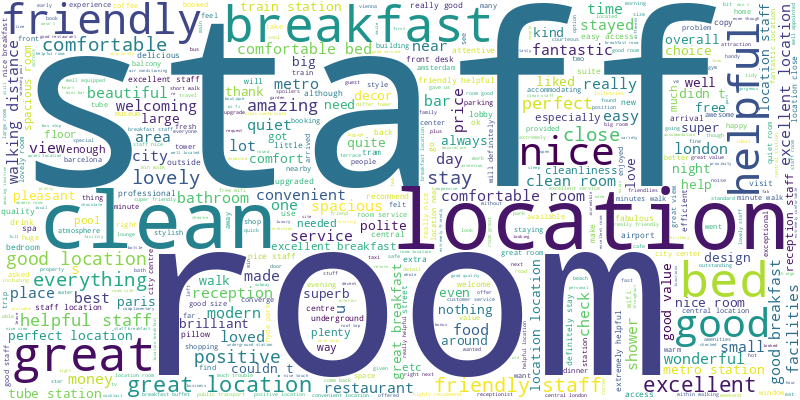

In [43]:
from wordcloud import WordCloud

long_string = ','.join(list(sam_pos_df['Review'].values))
wordcloud = WordCloud(background_color="white", max_words=500, contour_width=3, contour_color='steelblue', width=800, height=400)
wordcloud.generate(long_string)
wordcloud.to_image()

## WordCloud for Negative Reviews:

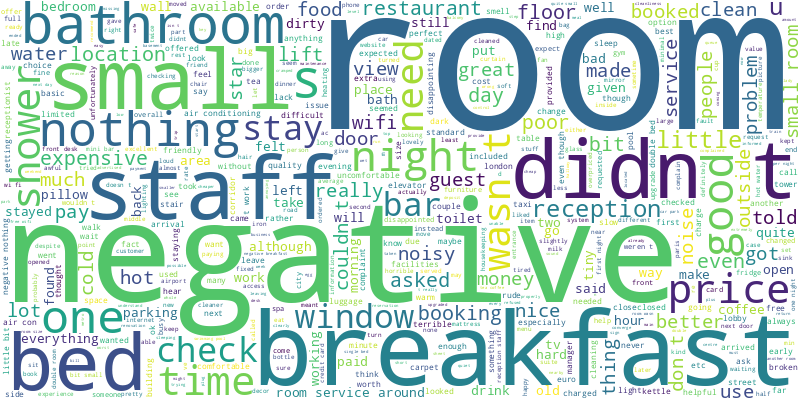

In [44]:
long_string = ','.join(list(sam_neg_df['Review'].values))
wordcloud = WordCloud(background_color="white", max_words=500, contour_width=3, contour_color='steelblue', width=800, height=400)
wordcloud.generate(long_string)
wordcloud.to_image()

In [45]:
pos_adj = [token.text.lower() for doc in positive_reviews.spacy_doc for token in doc if token.pos_ =='ADJ']
neg_adj = [token.text.lower() for doc in negative_reviews.spacy_doc for token in doc if token.pos_=='ADJ']

pos_noun = [token.text.lower() for doc in positive_reviews.spacy_doc for token in doc if token.pos_=='NOUN']
neg_noun = [token.text.lower() for doc in negative_reviews.spacy_doc for token in doc if token.pos_ == 'NOUN']

In [46]:
print('Positive Adjective: ',Counter(pos_adj).most_common(5))
print('Negative Adjective: ',Counter(neg_adj).most_common(5))
print('Positive Noun: ',Counter(pos_noun).most_common(5))
print('Negative Noun: ',Counter(neg_noun).most_common(5))

Positive Adjective:  [('good', 11817), ('great', 11100), ('friendly', 9441), ('helpful', 8424), ('nice', 7304)]
Negative Adjective:  [('small', 5322), ('little', 2315), ('good', 2207), ('expensive', 1747), ('poor', 1690)]
Positive Noun:  [('location', 20543), ('staff', 20518), ('room', 19043), ('hotel', 13695), ('breakfast', 9327)]
Negative Noun:  [('room', 21977), ('hotel', 8686), ('breakfast', 6152), ('negative', 6130), ('staff', 4163)]


In [48]:
import nltk

# Download stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [49]:
ENGLISH_STOP_WORDS = stopwords.words('english')

taking stop words from stopwords library and adding extra stop words:

In [50]:
stop_words = text.ENGLISH_STOP_WORDS.union(['didnt','did','havent', 'week', 'hi','wa','ha','day','today','really','also',
                                            'go', 'us', 'dont', 'got', 'im', 'ive','burger','food' ,'came', 'back',
                                           'get','try', 'would', 'time','good','great','service','didn','definitely','hotel','went','took','left',
                                            'check','told','asked','like','don','wasn','hotels','just','don','said','people','ve','stay','stayed',
                                           'loved','com','night','birthday','free','touch','little','given','making','hear','recommend','card','make',
                                           'feel','days','differ','thier','couldn','breakfast'])

In [52]:
vectorizer = CountVectorizer(stop_words=wordss)
doc_word = vectorizer.fit_transform(positive_reviews['Joined_text_lemmatize'])
doc_word.shape

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


NameError: name 'positive_words' is not defined

In [54]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [55]:
example = positive_reviews['Joined_text_lemmatize']

### LSA Topicing

In [57]:
from sklearn.feature_extraction.text import CountVectorizer

# Example: Define a sample DataFrame
positive_reviews = pd.DataFrame({
    'Joined_text_lemmatize': [
        "great hotel with amazing service",
        "the staff was excellent",
        "good food and clean rooms"
    ]
})

# Combine stop words
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words_nltk = stopwords.words('english')
wordss = stop_words_nltk  # If `positive_words` and `negative_words` aren't used

# Create the document-term matrix
vectorizer = CountVectorizer(stop_words=wordss)
doc_word = vectorizer.fit_transform(positive_reviews['Joined_text_lemmatize'])

# Verify the document-term matrix
print("Shape of document-term matrix:", doc_word.shape)


Shape of document-term matrix: (3, 10)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [63]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
import nltk
from nltk.corpus import stopwords

# Example dataset
positive_reviews = pd.DataFrame({
    'Joined_text_lemmatize': [
        "great hotel with amazing service",
        "the staff was excellent",
        "good food and clean rooms"
    ]
})

# Download NLTK stopwords
nltk.download('stopwords')
stop_words_nltk = stopwords.words('english')

# Create a document-term matrix
vectorizer = CountVectorizer(stop_words=stop_words_nltk)
doc_word = vectorizer.fit_transform(positive_reviews['Joined_text_lemmatize'])

# Apply TruncatedSVD
lsa = TruncatedSVD(n_components=3)
doc_topic = lsa.fit_transform(doc_word)

# Function to display topics
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print(f"\nTopic {ix}")
        else:
            print(f"\n{topic_names[ix]}")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Extract feature names
feature_names = vectorizer.get_feature_names_out()

# Display topics
display_topics(lsa, feature_names, 10)




Topic 0
rooms good food clean amazing excellent staff service hotel great

Topic 1
service hotel great amazing clean staff excellent rooms good food

Topic 2
staff excellent rooms good food clean service hotel great amazing


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### NMF Topicing

In [60]:
nmf_model = NMF(4)
doc_topic = nmf_model.fit_transform(doc_word)

In [65]:
display_topics(nmf_model, vectorizer.get_feature_names_out(), 10)



Topic 0
great service amazing hotel staff rooms good food excellent clean

Topic 1
rooms good food clean staff service hotel great excellent amazing

Topic 2
hotel amazing service great staff rooms good food excellent clean

Topic 3
staff excellent service rooms hotel great good food clean amazing


In [68]:
example = ["Review 1", "Review 2", "Review 3"]  # Match the number of rows in doc_topic
columns = ["Room_Condition", "Staff", "Station"]  # Match the number of columns in doc_topic

Vt = pd.DataFrame(doc_topic.round(5), index=example, columns=columns)
print(Vt)


          Room_Condition  Staff  Station
Review 1            -0.0    2.0 -0.00000
Review 2            -0.0   -0.0  1.41421
Review 3             2.0   -0.0  0.00000


## Corecx Topicing

### Topicing on Positive Reviews

In [73]:
print(positive_reviews.columns)


Index(['Joined_text_lemmatize'], dtype='object')


In [74]:
vectorizer = CountVectorizer(
    ngram_range=(1, 2),
    max_features=2000,
    stop_words=wordss,
    token_pattern=r'\b[a-z][a-z]+\b',
    binary=True
)

# Use the correct column name
doc_word = vectorizer.fit_transform(positive_reviews['Joined_text_lemmatize'])
words = list(np.asarray(vectorizer.get_feature_names_out()))


In [75]:
topic_model = ct.Corex(n_hidden=3, words=words, seed=1)
topic_model.fit(doc_word, words=words, docs=positive_reviews)
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: clean,clean rooms,food,food clean,good,good food,rooms,excellent,staff excellent
1: amazing,amazing service,great,great hotel,hotel
2: hotel amazing,service,staff


### Topicing on Negative Reviews

In [78]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk

# Example negative reviews DataFrame
negative_reviews = pd.DataFrame({
    'Review': [
        "the service was terrible and food was bad",
        "rooms were not clean and the staff was rude",
        "horrible experience, will not recommend"
    ]
})

# Download NLTK stopwords
nltk.download('stopwords')
stop_words_nltk = stopwords.words('english')

# Define custom negative words
custom_negative_words = ["terrible", "bad", "poor", "horrible", "dirty", "no", "not", "never"]

# Combine NLTK stop words with custom negative words
words_neg = stop_words_nltk + custom_negative_words

# Initialize CountVectorizer
vectorizer = CountVectorizer(
    ngram_range=(1, 3),
    max_features=2000,
    stop_words=words_neg,
    token_pattern=r'\b[a-z][a-z]+\b',
    binary=True
)

# Fit-transform negative reviews
doc_word = vectorizer.fit_transform(negative_reviews['Review'])
words = list(vectorizer.get_feature_names_out())

# Display the results
print("Shape of doc_word:", doc_word.shape)
print("Feature names:", words[:10])


Shape of doc_word: (3, 15)
Feature names: ['clean', 'clean staff', 'clean staff rude', 'experience', 'experience recommend', 'food', 'recommend', 'rooms', 'rooms clean', 'rooms clean staff']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [80]:
topics = topic_model.get_topics()
print(topics)


[[('clean', 0.7290328700921559, 1.0), ('clean staff', 0.7290328700921559, 1.0), ('clean staff rude', 0.7290328700921559, 1.0), ('rooms', 0.7290328700921559, 1.0), ('rooms clean', 0.7290328700921559, 1.0), ('rooms clean staff', 0.7290328700921559, 1.0), ('rude', 0.7290328700921559, 1.0), ('staff', 0.7290328700921559, 1.0), ('staff rude', 0.7290328700921559, 1.0)], [('experience', 0.7290328700921559, 1.0), ('experience recommend', 0.7290328700921559, 1.0), ('recommend', 0.7290328700921559, 1.0)], [('food', 0.7290328700921559, 1.0), ('service', 0.7290328700921559, 1.0), ('service food', 0.7290328700921559, 1.0)], [], []]


In [81]:
print("Shape of doc_word:", doc_word.shape)  # Should have non-zero rows and columns
print("First 10 words:", words[:10])        # Ensure words list is populated


Shape of doc_word: (3, 15)
First 10 words: ['clean', 'clean staff', 'clean staff rude', 'experience', 'experience recommend', 'food', 'recommend', 'rooms', 'rooms clean', 'rooms clean staff']


In [82]:
topic_model = ct.Corex(n_hidden=10, words=words, seed=1)  # Increase `n_hidden`
topic_model.fit(doc_word, words=words, docs=negative_reviews['Review'])  # Ensure proper input


In [83]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import corextopic.corextopic as ct
from nltk.corpus import stopwords
import nltk

# Sample DataFrame for negative reviews
negative_reviews = pd.DataFrame({
    'Review': [
        "the service was terrible and food was bad",
        "rooms were not clean and the staff was rude",
        "horrible experience, will not recommend"
    ]
})

# Download stop words
nltk.download('stopwords')
stop_words_nltk = stopwords.words('english')

# Define custom negative words
custom_negative_words = ["terrible", "bad", "poor", "horrible", "dirty", "no", "not", "never"]
words_neg = stop_words_nltk + custom_negative_words

# Vectorize the reviews
vectorizer = CountVectorizer(
    ngram_range=(1, 3),
    max_features=2000,
    stop_words=words_neg,
    token_pattern=r'\b[a-z][a-z]+\b',
    binary=True
)
doc_word = vectorizer.fit_transform(negative_reviews['Review'])
words = list(vectorizer.get_feature_names_out())

# Train Corex topic model
topic_model = ct.Corex(n_hidden=5, words=words, seed=1)
topic_model.fit(doc_word, words=words, docs=negative_reviews['Review'])

# Display topics
topics = topic_model.get_topics()
for n, topic in enumerate(topics):
    if topic:  # Check if topic is not empty
        topic_words, _, _ = zip(*topic)
        print(f'{n}: ' + ','.join(topic_words))
    else:
        print(f'{n}: No words identified for this topic.')


0: clean,clean staff,clean staff rude,rooms,rooms clean,rooms clean staff,rude,staff,staff rude
1: experience,experience recommend,recommend
2: food,service,service food
3: No words identified for this topic.
4: No words identified for this topic.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Clustring

In [84]:
def cluster(df):
    for i in df:
        lat = i['lat'].unique()
        lng = i['lng'].unique()
        loc = []
        for f, b in zip(lat, lng):
            loc.append([f,b])
        confert =pd.DataFrame(loc)
        confert.dropna(inplace=True)
        lat = confert[0].tolist()
        lng = confert[1].tolist()
        loc = []
        for f, b in zip(lat,lng):
            loc.append([f,b])

        X = StandardScaler().fit_transform(loc)
        db = DBSCAN(eps=0.15, min_samples=3).fit(X)

        # Let's find the observations DBSCAN called "core"
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

        unique_labels = set(labels)
        colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
        plt.figure(dpi=200)
        show_core = True
        show_non_core = True
        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Black used for noise.
                col = 'k'

            class_member_mask = (labels == k)
            if show_core:
                xy = X[class_member_mask & core_samples_mask]
                x, y = xy[:,0], xy[:,1]
                plt.scatter(x, y, c=col, edgecolors='k',  s=20, linewidths=1.1) # add black border for core points

            if show_non_core:
                xy = X[class_member_mask & ~core_samples_mask]
                x, y = xy[:,0], xy[:,1]
                plt.scatter(x, y, c=col, s=20, linewidths=1.1)

        plt.title('Estimated number of clusters: %d' % n_clusters_);

In [85]:
list_of_country_df = []
for i in range(len(df_all_data['Country'].value_counts().index)):
    list_of_country_df.append(df_all_data[(df_all_data["Country"] == df_all_data['Country'].value_counts().index[i])])

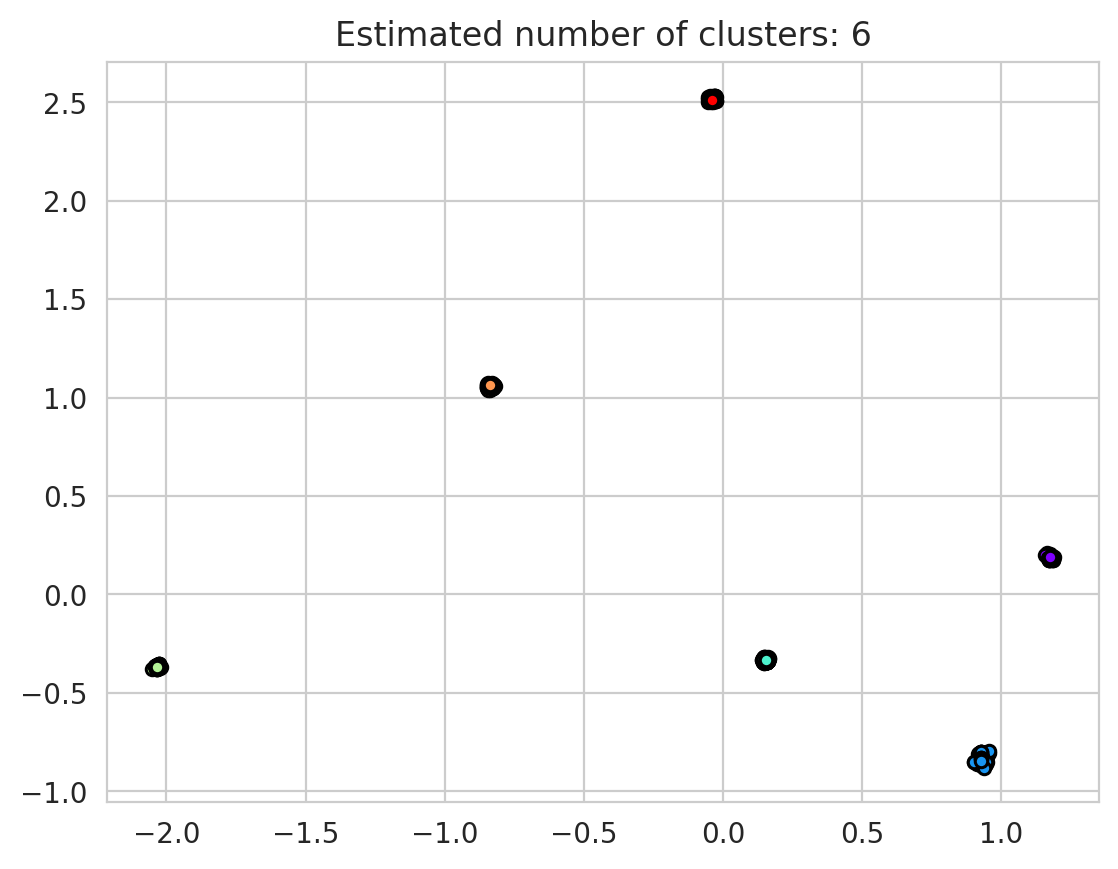

In [86]:
cluster([df_all_data])

### Cluster for hotels location in each country

In [88]:
from sklearn.cluster import KMeans
import numpy as np

# Example: Input data
list_of_country_df = [[1, 2], [3, 4], [5, 6]]  # Example 2D array

# Check the input shape
print("Input shape:", np.array(list_of_country_df).shape)

# Cluster function
def cluster(data):
    kmeans = KMeans(n_clusters=2, random_state=42)
    kmeans.fit(data)
    print("Cluster Centers:", kmeans.cluster_centers_)

# Call the function
cluster(list_of_country_df)


Input shape: (3, 2)
Cluster Centers: [[2. 3.]
 [5. 6.]]


# SVD Recommndation System

In [89]:
df_recommand = data_sample

In [90]:
df_reco = df_all_data[["Reviewer_Nationality" , "Hotel_Name" , "Reviewer_Score","Country"]]
df_reco

,Reviewer_Nationality,Hotel_Name,Reviewer_Score,Country
0,Russia,Hotel Arena,2.9,Netherlands
1,Ireland,Hotel Arena,7.5,Netherlands
2,Australia,Hotel Arena,7.1,Netherlands
3,United Kingdom,Hotel Arena,3.8,Netherlands
4,New Zealand,Hotel Arena,6.7,Netherlands
...,...,...,...,...
533929,Kuwait,Atlantis Hotel Vienna,7.0,Austria
533930,Estonia,Atlantis Hotel Vienna,5.8,Austria
533931,Egypt,Atlantis Hotel Vienna,2.5,Austria
533932,Mexico,Atlantis Hotel Vienna,8.8,Austria


In [91]:
df_reco = df_reco[df_reco["Reviewer_Nationality"] != " "]
df_reco.Reviewer_Nationality = df_reco.Reviewer_Nationality.str.strip()

In [92]:
df_reco['Country'].value_counts().index

Index(['United Kingdom', 'France', 'Spain', 'Netherlands', 'Austria', 'Italy',
       '', 'Mirabeau'],
      dtype='object', name='Country')

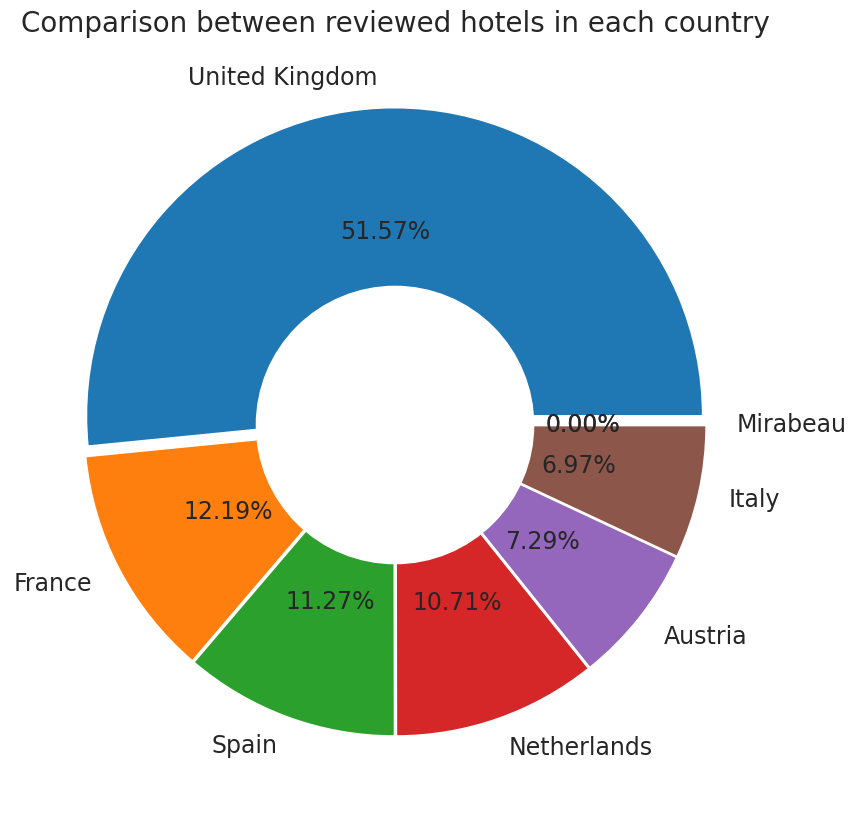

In [94]:
import matplotlib.pyplot as plt

# Get the value counts and their indices
country_counts = df_reco['Country'].value_counts()
countries = list(country_counts.index)

# Dynamically create the explode list with the same length as the number of countries
explode = [0.03] + [0.01] * (len(countries) - 1)

# Create the pie chart
plt.figure(figsize=(10, 10))
plt.pie(
    x=country_counts,
    labels=countries,
    autopct='%.2f%%',
    textprops={'fontsize': 17},
    explode=explode
)
plt.title('Comparison between reviewed hotels in each country', fontdict={'fontsize': 20})

# Add a white circle in the center to create a donut chart effect
centre_circle = plt.Circle((0, 0), 0.45, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Display the chart
plt.show()


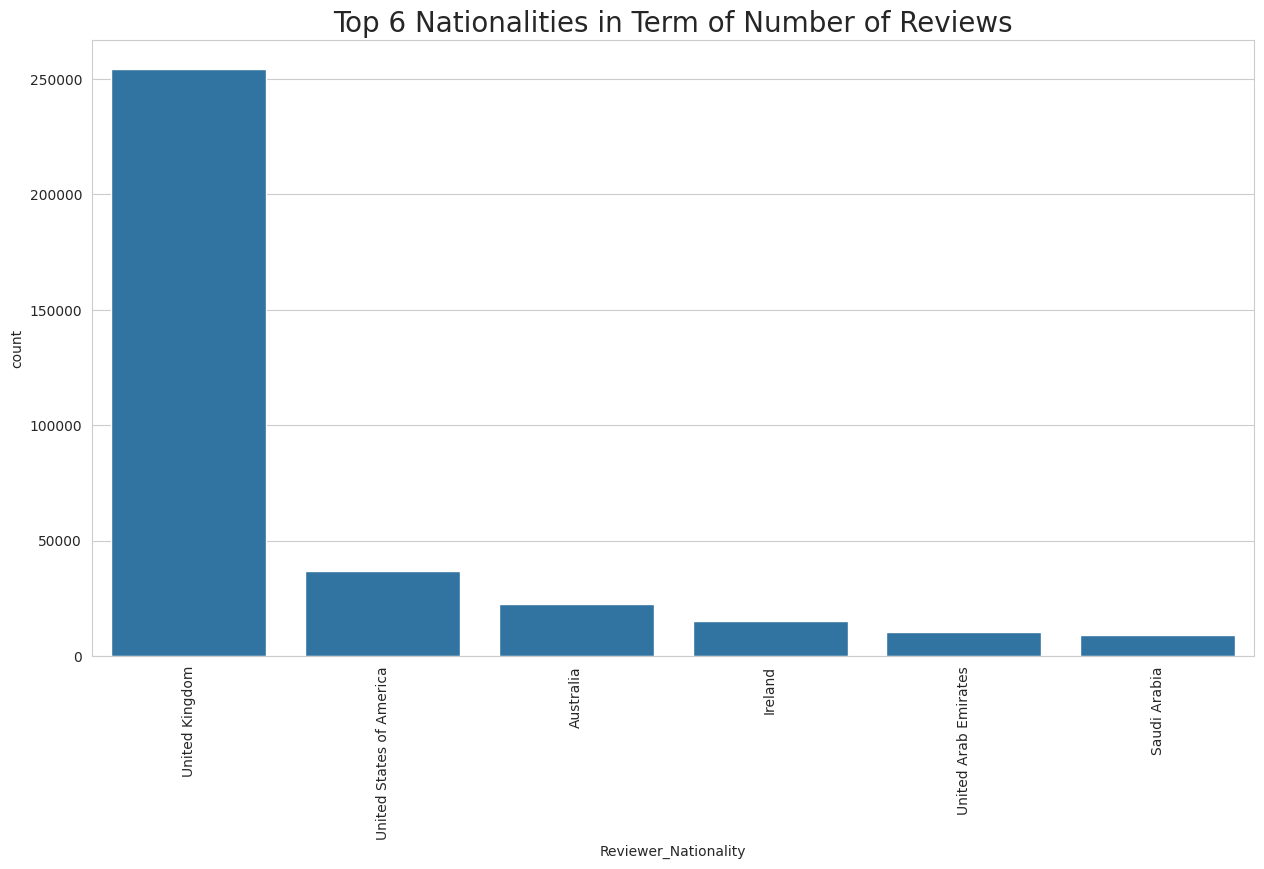

In [95]:
df_top_6 = df_reco[(df_reco['Reviewer_Nationality'] == "United Kingdom") | (df_reco['Reviewer_Nationality'] == "United States of America") |(df_reco['Reviewer_Nationality'] == "Australia") | (df_reco['Reviewer_Nationality'] == "Ireland") |(df_reco['Reviewer_Nationality'] == "United Arab Emirates") | (df_reco['Reviewer_Nationality'] == "Saudi Arabia")]
plt.figure(figsize=(15,8))
sns.countplot(x='Reviewer_Nationality',data=df_top_6 ,order = df_top_6['Reviewer_Nationality'].value_counts().index)
plt.title('Top 6 Nationalities in Term of Number of Reviews',fontdict={'fontsize':20})
plt.xticks(rotation=90);

In [96]:
df_high_all = df_reco[(df_reco["Reviewer_Score"] >= 8)]
df_high_all

,Reviewer_Nationality,Hotel_Name,Reviewer_Score,Country
7,United Kingdom,Hotel Arena,10.0,Netherlands
10,United Kingdom,Hotel Arena,10.0,Netherlands
13,Italy,Hotel Arena,9.2,Netherlands
14,Canada,Hotel Arena,8.8,Netherlands
15,Italy,Hotel Arena,10.0,Netherlands
...,...,...,...,...
533920,India,Atlantis Hotel Vienna,8.3,Austria
533925,Brazil,Atlantis Hotel Vienna,10.0,Austria
533928,Kuwait,Atlantis Hotel Vienna,10.0,Austria
533932,Mexico,Atlantis Hotel Vienna,8.8,Austria


In [97]:
df_reco['Country'].value_counts().index

Index(['United Kingdom', 'France', 'Spain', 'Netherlands', 'Austria', 'Italy',
       '', 'Mirabeau'],
      dtype='object', name='Country')

In [98]:
list_of_country_df = []
for i in range(len(df_reco['Country'].value_counts().index)):
    list_of_country_df.append(df_high_all[(df_high_all["Country"] == df_reco['Country'].value_counts().index[i])])
    list_of_country_df[i] = list_of_country_df[i][["Reviewer_Nationality" , "Hotel_Name"]]
    list_of_country_df[i] = pd.get_dummies(list_of_country_df[i] , columns =["Hotel_Name"])
    list_of_country_df[i] = list_of_country_df[i].drop_duplicates()
    list_of_country_df[i] = list_of_country_df[i].groupby("Reviewer_Nationality").sum()

In [99]:
def plot_3D_reco(df):
    U, Sigma, VT = svd(df)
    plt.style.use('seaborn')

    fig = plt.figure(figsize=(20,16))
    ax = fig.gca(projection='3d')
    ax.scatter(U[:,0],U[:,1],U[:,2],c='k',s=150);
    ax.set_xlabel("D1", fontsize=20, labelpad=20)
    ax.set_ylabel("D2", fontsize=20, labelpad=20)
    ax.set_zlabel("D3", fontsize=20, labelpad=20);

    lbls = df.index
    offset = 0.02
    for i, txt in enumerate(lbls):
        if i not in [6,7]:
            ax.text(U[i,0]+offset,U[i,1],U[i,2],txt, fontsize=20)
        else:
            ax.text(U[i,0]+offset,U[i,1],U[i,2]+5*offset,txt, fontsize=20)

In [101]:
!pip install seaborn


In [103]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3D_reco(data):
    """
    Plot data in 3D.

    Parameters:
    - data: A DataFrame or 2D array with at least three columns for x, y, z axes.
    """
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Assuming 'x', 'y', 'z' are columns in the data
    ax.scatter(data.iloc[:, 0], data.iloc[:, 1], data.iloc[:, 2], c='blue', marker='o')

    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')

    plt.title('3D Plot of Recommendations')
    plt.show()


In [104]:
def get_recommends_user(userID, df ,Nationalities , Hotels):
    U, Sigma, VT = svd(df)
    userrecs = []
    for user in range(U.shape[0]):
        if user!= userID:
            userrecs.append([user,np.dot(U[userID],U[user])])
    final_rec = [i[0] for i in sorted(userrecs,key=lambda x: x[1],reverse=True)]
    comp_user = final_rec[0]
    print("Users from %s are most similar to users from %s."% (User_Nationality_list[userID], User_Nationality_list[comp_user]))
    rec_likes = df.iloc[comp_user]
    current = df.iloc[userID]
    recs = []
    for i,item in enumerate(current):
        if item != rec_likes[i] and rec_likes[i]!=0:
            recs.append(i)
    return recs

In [106]:
user_nation = 'Saudi Arabia'
print(f"=========People from {user_nation}========= ")

i = 0
for df in list_of_country_df:
    country_name = df_reco['Country'].value_counts().index[i]
    print(f"\n\n===Recommended hotels in {country_name}===")

    # Clean index
    df.index = df.index.str.strip().str.title()
    User_Nationality_list = df.index
    Hotel_names_list = df.columns.str.replace("Hotel_Name_", "")

    # Check if user_nation exists
    if user_nation not in User_Nationality_list:
        print(f"'{user_nation}' is not in the list of available nationalities for this DataFrame.")
        continue

    user_nation_index = list(User_Nationality_list).index(user_nation)
    recommended_hotels = get_recommends_user(user_nation_index, df, User_Nationality_list, Hotel_names_list)

    if len(recommended_hotels) > 10:
        recommended_hotels_first_10 = recommended_hotels[0:10]
    else:
        recommended_hotels_first_10 = recommended_hotels

    print(f"There are {len(recommended_hotels)} hotels that people from {User_Nationality_list[user_nation_index]} did not visit, they might like.")
    print(f"\n{len(recommended_hotels_first_10)} Hotels for people from {User_Nationality_list[user_nation_index]} to check out:\n",
          list(Hotel_names_list[recommended_hotels_first_10]))
    i += 1


=========People from Saudi Arabia========= 


===Recommended hotels in United Kingdom===
Users from Saudi Arabia are most similar to users from Serbia.
There are 7 hotels that people from Saudi Arabia did not visit, they might like.

7 Hotels for people from Saudi Arabia to check out:
 ['DoubleTree By Hilton London Excel', 'Grange Rochester Hotel', 'London Marriott Hotel Kensington', 'NH London Kensington', 'Novotel London Waterloo', 'The Justin James Hotel', 'The Premier Notting Hill']


===Recommended hotels in France===
Users from Saudi Arabia are most similar to users from Turkey.
There are 70 hotels that people from Saudi Arabia did not visit, they might like.

10 Hotels for people from Saudi Arabia to check out:
 ['9Hotel Republique', 'A La Villa Madame', 'Artus Hotel by MH', 'Au Manoir Saint Germain', 'B Montmartre', 'Best Western Plus 61 Paris Nation Hotel', 'Best Western Plus Elys e Secret', 'Best Western Premier Louvre Saint Honor ', 'Best Western Premier Op ra Faubourg Ex Ho

# Recommndation System

In [107]:
recom_data = df_recommand[df_recommand['Reviewer_Score'] >= 8]
recom_data = recom_data[['Reviewer_Nationality','Hotel_Name']]
recom_data.drop_duplicates(inplace=True)
recom_data.Reviewer_Nationality = recom_data.Reviewer_Nationality.str.strip()


In [108]:
recom_data = recom_data[recom_data['Reviewer_Nationality'] != 'United Kingdom']
recom_data = recom_data[recom_data['Reviewer_Nationality'] != 'United States of America']
recom_data = recom_data[recom_data['Reviewer_Nationality'] != 'Australia']
recom_data = recom_data[recom_data['Reviewer_Nationality'] != 'Ireland']

In [109]:
user_hotel_map = defaultdict(list)
hotel_user_map = defaultdict(list)

In [110]:
data_recom = pd.DataFrame(recom_data)
data_recom.to_csv(r'data_rec.csv', index=False)

In [111]:
with open('data_rec.csv', 'r') as csvfile:
    w = csv.reader(csvfile)
    for row in w:
        user_hotel_map[row[0]].append(row[1])
        hotel_user_map[row[1]].append(row[0])

In [112]:
def get_similar_hotel(user_hotel_map,hotel_user_map,m):
    biglist = []
    for u in hotel_user_map[m]:
        biglist.extend(user_hotel_map[u])
    return Counter(biglist).most_common(4)[1:]

In [113]:
def get_hotel_recommendation(user_hotel_map,hotel_user_map,u1):
    biglist = []
    for m in user_hotel_map[u1]:
        for u in hotel_user_map[m]:
            biglist.extend(user_hotel_map[u])
    return Counter(biglist).most_common(3)

In [114]:
def get_similar_users(user_hotel_map,hotel_user_map,m):
    hotel_user_map
    user_hotel_map
    biglist = []
    for u in user_hotel_map[m]:
        biglist.extend(hotel_user_map[u])
    return Counter(biglist).most_common(4)[1:]

In [115]:
get_similar_hotel(user_hotel_map,hotel_user_map,'The Kensington Hotel')

[('The Student Hotel Amsterdam City', 12),
 ('Park Plaza Westminster Bridge London', 11),
 ('The Square Milano Duomo', 11)]

In [116]:
get_hotel_recommendation(user_hotel_map,hotel_user_map,'Saudi Arabia')

[('Park Plaza Westminster Bridge London', 6742),
 ('The Student Hotel Amsterdam City', 6183),
 ('citizenM Tower of London', 5787)]

In [117]:
country = 'Kuwait'
get_similar_users(user_hotel_map,hotel_user_map,country)

[('United Arab Emirates', 201), ('Saudi Arabia', 184), ('Canada', 168)]

# Modeling

In [118]:
def get_scores(model,X_train,X_val):
    model.fit(X_train,y_train)
    print(f'Traing score: {model.score(X_train,y_train)}')
    print(f'Val score:    {model.score(X_val,y_val)}')
    print( f"F1 score:    {f1_score(model.predict(X_val),y_val)}")
    print(f'Precision score: {precision_score(y_val,model.predict(X_val))}')
    print(f'Recall score: {recall_score(y_val,model.predict(X_val))}')
    print(f'accuracy score: {accuracy_score(y_val, model.predict(X_val))}')

In [119]:
X = data_sample.Review
y = data_sample.Sentiment

In [120]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.05 , random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.0534, random_state=42)

In [121]:
from sklearn.feature_extraction.text import CountVectorizer

cv1 = CountVectorizer()

X_train_cv1 = cv1.fit_transform(X_train)
X_val_cv1  = cv1.transform(X_val)

In [122]:
lr = LogisticRegression()
get_scores(lr,X_train_cv1,X_val_cv1)

Traing score: 0.9537291358546377
Val score:    0.9444115907746895
F1 score:    0.9480854197349042
Precision score: 0.9515890613451589
Recall score: 0.9446074834922964
accuracy score: 0.9444115907746895


In [123]:
bnb = BernoulliNB()
get_scores(bnb,X_train_cv1,X_val_cv1)

Traing score: 0.8871862733105741
Val score:    0.885866351271437
F1 score:    0.8991816123977016
Precision score: 0.8558170367915148
Recall score: 0.9471753484959647
accuracy score: 0.885866351271437


In [124]:
DTC = DecisionTreeClassifier()
get_scores(DTC,X_train_cv1,X_val_cv1)

Traing score: 0.9911261356433552
Val score:    0.8984821604573231
F1 score:    0.9055912007332723
Precision score: 0.9050934408208134
Recall score: 0.9060895084372708
accuracy score: 0.8984821604573231


In [125]:
tfidf1 = TfidfVectorizer()

X_train_tfidf1 = tfidf1.fit_transform(X_train)
X_val_tfidf1  = tfidf1.transform(X_val)
get_scores(lr,X_train_tfidf1,X_val_tfidf1)

Traing score: 0.9483136321683143
Val score:    0.947565543071161
F1 score:    0.9507589781562384
Precision score: 0.9596412556053812
Recall score: 0.942039618488628
accuracy score: 0.947565543071161


In [126]:
bnb = BernoulliNB()
get_scores(bnb,X_train_tfidf1,X_val_tfidf1)

Traing score: 0.8871862733105741
Val score:    0.885866351271437
F1 score:    0.8991816123977016
Precision score: 0.8558170367915148
Recall score: 0.9471753484959647
accuracy score: 0.885866351271437


In [127]:
DTC = DecisionTreeClassifier()
get_scores(DTC,X_train_tfidf1,X_val_tfidf1)

Traing score: 0.9911038953818097
Val score:    0.8953282081608516
F1 score:    0.9025509267755552
Precision score: 0.9030481087036357
Recall score: 0.9020542920029347
accuracy score: 0.8953282081608516


# Final model

In [128]:
model = LogisticRegression()
tfidf1 = TfidfVectorizer()
X_train_val_tfidf1 = tfidf1.fit_transform(X_train_val)
X_test_tfidf1  = tfidf1.transform(X_test)
model.fit(X_train_val_tfidf1 ,y_train_val)
print(f'Traing score: {model.score(X_train_val_tfidf1,y_train_val)}')
print(f'Val score:    {model.score(X_test_tfidf1,y_test)}')
print( f"F1 score:    {f1_score(model.predict(X_test_tfidf1),y_test)}")
print(f'Precision score: {precision_score(y_test,model.predict(X_test_tfidf1))}')
print(f'Recall score: {recall_score(y_test,model.predict(X_test_tfidf1))}')
print(f'accuracy score: {accuracy_score(y_test, model.predict(X_test_tfidf1))}')

Traing score: 0.9484526315789473
Val score:    0.9424
F1 score:    0.9453095328522598
Precision score: 0.9547372458764863
Recall score: 0.9360661902971041
accuracy score: 0.9424
